In [1]:
import pygetwindow as gw
from PIL import ImageGrab
import psutil
import os
import time
import threading
import cv2
import numpy as np
import keyboard
import pygetwindow as gw
import mss
import ctypes
import matplotlib.pyplot as plt
import pyautogui
from pynput.keyboard import Key, Controller
from directkeys import *

UP = 0xC8
LEFT = 0xCB
RIGHT = 0xCD
DOWN = 0xD0
TWO = 0x2
THREE = 0x3

In [2]:
def get_process_id_by_name(process_name):
    for process in psutil.process_iter(['pid', 'name']):
        if process.info['name'] == process_name:
            return process.info['pid']
    return None

def get_active_window_process_id():
    active_window = ctypes.windll.user32.GetForegroundWindow()
    process_id = ctypes.c_ulong(0)
    ctypes.windll.user32.GetWindowThreadProcessId(active_window, ctypes.byref(process_id))
    return process_id.value

def preprocess_image_with_canny(image):
    screenshot_np = np.array(image)

    processed_img = cv2.cvtColor(screenshot_np, cv2.COLOR_RGB2GRAY)
    processed_img = cv2.Canny(processed_img, threshold1=200, threshold2=300)

    return processed_img

def crop_image(np_image):
    height, width = np_image.shape
    x, y = 0, int(height / 3)

    cropped_image = np_image[y:y+height, x:x+width]

    return cropped_image

def delete_short_lines(np_image, min_length):
    canny_image = cv2.Canny(np_image, threshold1=100, threshold2=200)

    # Визначимо розмір ядра для діляції
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Застосуємо діляцію для збільшення розміру ліній
    thick_lines_image = cv2.dilate(canny_image, kernel, iterations=1)

    # Показати зображення з товстими лініями
    # plt.imshow(cv2.cvtColor(thick_lines_image, cv2.COLOR_BGR2RGB))
    # plt.show()

    contours, _ = cv2.findContours(thick_lines_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Видалення ліній, які коротші за min_length пікселів
    filtered_image = thick_lines_image.copy()

    for contour in contours:
        if cv2.arcLength(contour, True) < min_length:
            cv2.drawContours(filtered_image, [contour], -1, 0, -1)

    return filtered_image

def draw_black_bbox(np_image, x_min, y_min, x_max, y_max):
    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            np_image[i][j] = 0

def distance_to_first_white_pixel(np_image, start_point, dx, dy):
    x, y = start_point
    while 0 <= x < np_image.shape[1] and 0 <= y < np_image.shape[0]:
        if np_image[int(y), int(x)] == 255:
            break

        x += dy
        y += dx

    # Знайдена точка, де перший білий піксель перетинається з променем
    end_point = (int(x), int(y))
    # Знайдена відстань
    distance = np.sqrt((end_point[0] - start_point[0])**2 + (end_point[1] - start_point[1])**2)

    return end_point, distance

In [14]:
process_name = "Trackmania.exe"  # Назва процесу, для якого ви хочете отримати ідентифікатор
process_id = get_process_id_by_name(process_name)

keyboard = Controller()

while True:
    active_process_id = get_active_window_process_id()  

    if process_id == active_process_id:
        start_time = time.time()
        PressKey(UP)
        PressKey(TWO)

        print("match")

        printscreen =  ImageGrab.grab()
        
        processed_img = preprocess_image_with_canny(printscreen)

        cropped_image = crop_image(processed_img)

        filtered_image = delete_short_lines(cropped_image, 500)

        draw_black_bbox(filtered_image, 300, 800, 719, 1230)

        start_point = (960, 500)
        dx = -1
        max_distance = 0
        final_point = ()
        final_angle = ()

        plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))

        for dy in range(-20, 21, 5):
            end_point, distance = distance_to_first_white_pixel(filtered_image, start_point, dx, dy / 50)
            x_end, y_end = end_point
            plt.scatter(x_end, y_end, color='green', marker='o', s=20)

            if distance > max_distance:
                max_distance = distance
                final_point = end_point
                final_angle = (dx, dy)

        _, angle = final_angle

        x_start, y_start = start_point
        plt.scatter(x_start, y_start, color='red', marker='o', s=50)

        print(angle)
        if angle < -5:
            ReleaseKey(RIGHT)
            PressKey(LEFT)

        elif angle > 5:
            ReleaseKey(LEFT)
            PressKey(RIGHT)

        else:
            ReleaseKey(LEFT)
            ReleaseKey(RIGHT)

        plt.show()
        end_time = time.time()
        print("execute time:", end_time - start_time)

KeyboardInterrupt: 

In [ ]:
def distance_to_first_white_pixel(np_image, start_point, dx, dy):
    x, y = start_point
    while 0 <= x < np_image.shape[1] and 0 <= y < np_image.shape[0]:
        if np_image[int(y), int(x)] == 255:
            break

        x += dy
        y += dx

    # Знайдена точка, де перший білий піксель перетинається з променем
    end_point = (int(x), int(y))
    # Знайдена відстань
    distance = np.sqrt((end_point[0] - start_point[0])**2 + (end_point[1] - start_point[1])**2)

    return end_point, distance

0.013963460922241211
0.0009980201721191406
0.012587785720825195
0.06194162368774414
(-1, -30)
end time: 0.4342765808105469


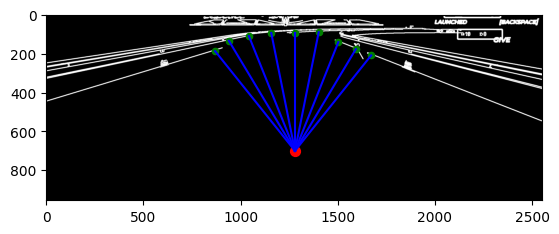

In [21]:
start_time = time.time()
printscreen = cv2.imread('./../data/trackmania-screenshots/example_of_view.png')

preprocess_image_with_canny_start = time.time()
processed_img = preprocess_image_with_canny(printscreen)
preprocess_image_with_canny_end = time.time()

print(preprocess_image_with_canny_end - preprocess_image_with_canny_start)

crop_image_start = time.time()
cropped_image = crop_image(processed_img)
crop_image_end = time.time()

print(crop_image_end - crop_image_start)

delete_short_lines_start = time.time()
filtered_image = delete_short_lines(cropped_image, 500)
delete_short_lines_end = time.time()

print(delete_short_lines_end - delete_short_lines_start)

draw_black_bbox(filtered_image, 400, 1000, 954, 1550)

start_point = (1280, 700)
dx = -1
max_distance = 0
final_point = ()
final_angle = ()

plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))

x_start, y_start = start_point
plt.scatter(x_start, y_start, color='red', marker='o', s=50)

distance_to_first_white_pixel_start = time.time()
for dy in range(-40, 41, 10):
    end_point, distance = distance_to_first_white_pixel(filtered_image, start_point, dx, dy / 50)
    x_end, y_end = end_point
    x = [x_start, x_end]
    y = [y_start, y_end]

    # Побудова відрізка
    plt.plot(x, y, linestyle='-', color='b')
    plt.scatter(x_end, y_end, color='green', marker='o', s=20)

    if distance > max_distance:
        max_distance = distance
        final_point = end_point
        final_angle = (dx, dy)
distance_to_first_white_pixel_end = time.time()

print(distance_to_first_white_pixel_end - distance_to_first_white_pixel_start)

_, angle = final_angle

print(final_angle)

end_time = time.time()
print("end time:", end_time - start_time)

plt.show()